In [135]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [136]:
import os

In [137]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Model

In [138]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [139]:
device

0

In [140]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model= model_name,
        device= device
    )

    return theme_classifier


In [141]:
theme_classifier = load_model(device)

c:\Users\salvi\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [142]:
theme_list = ["Adventure", "Friendship", "Dreams", "Freedom", "Loyalty", "Courage", "Justice", "Ambition", "Sacrifice", "Perseverance", "Family", "Heroism", "Rivalry", "Exploration", "Redemption", "Unity", "Hope", "Determination", "Survival", "Betrayal"]

# Load Dataset

In [143]:
files = glob('../data/subtitles/*.ass')
files[-1]

'../data/subtitles\\999.ass'

In [144]:
files_sorted = sorted(files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

In [145]:
files_sorted[-1]

'../data/subtitles\\1112.ass'

In [146]:
with open(files[0],'r') as files_sorted:
    lines = files_sorted.readlines()
    lines = lines[27:] #Meta data in subs
    lines =  [ ",".join(line.split(',')[9:])  for line in lines ] # 9 because first 9 columns are meta data

In [147]:
lines = [ line.replace('\\N',' ') for line in lines]


In [148]:
" ".join(lines[:10])

"Gold Roger, the King of the Pirates,\n attained everything this world has to offer.\n The words he uttered just before his death drove people to the seas.\n My treasure? If you want it, you can have it!\n Find it! I left everything this world has to offer there!\n And so men head for the Grand Line in pursuit of their dreams!\n The world has truly entered a Great Pirate Era!\n We're going to gather up all our dreams\n and set out in search of something to find\n ONE PIECE!\n"

In [149]:
#episode number
int(files[-1].split('\\')[-1].split('.')[0].strip())

999

In [150]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')
    sub_sorted = sorted(subtitles_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    scripts=[]
    episode_num=[]

    for path in sub_sorted:

        #Read Lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('\\')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [151]:
dataset_path = "../data/subtitles"
df = load_subtitles_dataset(dataset_path)

In [152]:
df.head(10)

,episode,script
0,1,"Gold Roger, the King of the Pirates,\n attaine..."
1,2,"Gold Roger, the King of the Pirates,\n attaine..."
2,3,"Gold Roger, the King of the Pirates,\n attaine..."
3,4,"Gold Roger, the King of the Pirates,\n attaine..."
4,5,"Gold Roger, the King of the Pirates,\n attaine..."
5,6,"Gold Roger, the King of the Pirates,\n attaine..."
6,7,"Gold Roger, the King of the Pirates,\n attaine..."
7,8,"Gold Roger, the King of the Pirates,\n attaine..."
8,9,"Gold Roger, the King of the Pirates,\n attaine..."
9,10,"Gold Roger, the King of the Pirates,\n attaine..."


In [153]:
df.tail()

,episode,script
1010,1074,...
1011,1075,...
1012,1076,...
1013,1077,...
1014,1112,...



dividing senetence so that it can fit in nlp token maximum this is done using sent_tokenize()


In [154]:
script = df.iloc[0]['script']
script_sentences = sent_tokenize(script)
script_sentences[:3]
# Batch Sentence
sentence_batch_size=20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [155]:
script_batches[:2]


['Gold Roger, the King of the Pirates,\n attained everything this world has to offer. The words he uttered just before his death drove people to the seas. My treasure? If you want it, you can have it! Find it! I left everything this world has to offer there! And so men head for the Grand Line in pursuit of their dreams! The world has truly entered a Great Pirate Era! We\'re going to gather up all our dreams\n and set out in search of something to find\n ONE PIECE! Compasses only cause delays\n Delirious with fever, I take the helm\n If the dusty treasure map has been verified, it\'s not a legend! When it comes to personal storms,\n simply ride aboard someone else\'s biorhythm\n and pretend it isn\'t there! We\'re going to gather up all our dreams\n and set out in search of something to find\n A coin in my pocket, and do you wanna be my friend? We are, We are on the cruise! We are! Whoa...\n "I\'m Luffy! The Man Who\'s Gonna be King of the Pirates!" No worries! A whirlpool of that size 

In [156]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [157]:
theme_output


[{'sequence': 'Gold Roger, the King of the Pirates,\n attained everything this world has to offer. The words he uttered just before his death drove people to the seas. My treasure? If you want it, you can have it! Find it! I left everything this world has to offer there! And so men head for the Grand Line in pursuit of their dreams! The world has truly entered a Great Pirate Era! We\'re going to gather up all our dreams\n and set out in search of something to find\n ONE PIECE! Compasses only cause delays\n Delirious with fever, I take the helm\n If the dusty treasure map has been verified, it\'s not a legend! When it comes to personal storms,\n simply ride aboard someone else\'s biorhythm\n and pretend it isn\'t there! We\'re going to gather up all our dreams\n and set out in search of something to find\n A coin in my pocket, and do you wanna be my friend? We are, We are on the cruise! We are! Whoa...\n "I\'m Luffy! The Man Who\'s Gonna be King of the Pirates!" No worries! A whirlpool 

In [158]:
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

themes = {key: np.mean(np.array(value)) for key,value in themes.items()}


In [159]:
dict(sorted(themes.items(), key=lambda item: item[1],reverse=True))

{'Adventure': 0.838525801897049,
 'Rivalry': 0.8138233423233032,
 'Survival': 0.728201150894165,
 'Exploration': 0.7229622602462769,
 'Betrayal': 0.6016936898231506,
 'Ambition': 0.5284432023763657,
 'Dreams': 0.4982219059020281,
 'Heroism': 0.45916150510311127,
 'Friendship': 0.4474483703961596,
 'Determination': 0.37981516867876053,
 'Perseverance': 0.37451955676078796,
 'Courage': 0.33867449313402176,
 'Justice': 0.3137959986925125,
 'Redemption': 0.29927971214056015,
 'Freedom': 0.2907579392194748,
 'Loyalty': 0.2770996391773224,
 'Unity': 0.26965679228305817,
 'Sacrifice': 0.21064133942127228,
 'Family': 0.15046992897987366,
 'Hope': 0.08318039728328586}

In [160]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    #Batch Sentence 
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    #Run Model 
    theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
    )
    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes


    

In [161]:
df1 = df.head(3)
df1

,episode,script
0,1,"Gold Roger, the King of the Pirates,\n attaine..."
1,2,"Gold Roger, the King of the Pirates,\n attaine..."
2,3,"Gold Roger, the King of the Pirates,\n attaine..."


In [162]:
df1.script[0]

'Gold Roger, the King of the Pirates,\n attained everything this world has to offer.\n The words he uttered just before his death drove people to the seas.\n My treasure? If you want it, you can have it!\n Find it! I left everything this world has to offer there!\n And so men head for the Grand Line in pursuit of their dreams!\n The world has truly entered a Great Pirate Era!\n We\'re going to gather up all our dreams\n and set out in search of something to find\n ONE PIECE!\n Compasses only cause delays\n Delirious with fever, I take the helm\n If the dusty treasure map has been verified, it\'s not a legend!\n When it comes to personal storms,\n simply ride aboard someone else\'s biorhythm\n and pretend it isn\'t there!\n We\'re going to gather up all our dreams\n and set out in search of something to find\n A coin in my pocket, and do you wanna be my friend?\n We are, We are on the cruise!\n We are!\n Whoa...\n "I\'m Luffy! The Man Who\'s Gonna be King of the Pirates!"\n No worries!\

In [163]:
output_themes = df1['script'].apply(get_themes_inference)

In [164]:
theme_df = pd.DataFrame(output_themes.tolist())


In [165]:
theme_df

,Dreams,Adventure,Exploration,Friendship,Ambition,Rivalry,Heroism,Survival,Determination,Courage,Loyalty,Freedom,Justice,Redemption,Betrayal,Unity,Perseverance,Sacrifice,Family,Hope
0,0.498222,0.838526,0.722962,0.447448,0.528443,0.813823,0.459162,0.728201,0.379815,0.338674,0.277100,0.290758,0.313796,0.299280,0.601694,0.269657,0.374520,0.210641,0.150470,0.083180
1,0.530880,0.854885,0.699547,0.633825,0.607927,0.594232,0.525002,0.713001,0.484291,0.485585,0.298067,0.449086,0.476706,0.446018,0.373021,0.410017,0.427833,0.393756,0.287565,0.214348
2,0.499065,0.673469,0.602411,0.424214,0.645272,0.839882,0.480221,0.545932,0.393997,0.375692,0.219863,0.295814,0.257063,0.285671,0.421734,0.160776,0.280584,0.292326,0.141256,0.068983


In [166]:
df1[theme_df.columns] = theme_df

C:\Users\salvi\AppData\Local\Temp\ipykernel_24656\1777267100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[theme_df.columns] = theme_df
C:\Users\salvi\AppData\Local\Temp\ipykernel_24656\1777267100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[theme_df.columns] = theme_df
C:\Users\salvi\AppData\Local\Temp\ipykernel_24656\1777267100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

# Visualize Output

In [167]:
theme_output = df1.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,Dreams,1.528167
1,Adventure,2.366879
2,Exploration,2.024920
3,Friendship,1.505487
4,Ambition,1.781642
5,Rivalry,2.247937
6,Heroism,1.464385
7,Survival,1.987134
8,Determination,1.258103
9,Courage,1.199952


In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

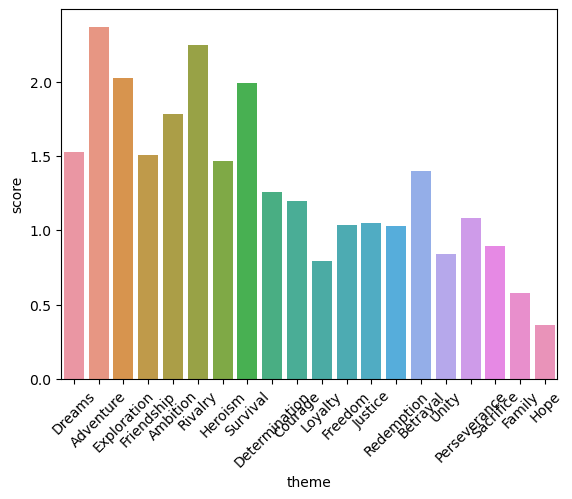

In [169]:
sns.barplot(data = theme_output ,x="theme",y="score" )
plt.xticks(rotation=45)
plt.show()